In [2]:
!which python

/home/raameshb/miniforge3/envs/echotorch2/bin/python


In [1]:
# Imports
import torch
from echotorch.datasets.NARMADataset import NARMADataset
import echotorch.nn.reservoir as etrs
import echotorch.utils
import echotorch.utils.matrix_generation as mg
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Length of training samples
train_sample_length = 5000

# Length of test samples
test_sample_length = 2000

# How many training/test samples
n_train_samples = 1
n_test_samples = 1

# Batch size (how many sample processed at the same time?)
batch_size = 1

In [5]:
# Reservoir hyper-parameters
spectral_radius = 1.07
leaky_rate = 0.9261
input_dim = 1
reservoir_size = 410
connectivity = 0.1954
ridge_param = 0.00000409
input_scaling = 0.9252
bias_scaling = 0.079079

In [6]:
# Predicted/target plot length
plot_length = 200

In [7]:
# Use CUDA?
use_cuda = False
use_cuda = torch.cuda.is_available() if use_cuda else False

use_cuda

False

In [8]:
# Manual seed initialisation
np.random.seed(1)
torch.manual_seed(1)

In [9]:
# NARMA30 dataset
narma10_train_dataset = NARMADataset(train_sample_length, n_train_samples, system_order=10)
narma10_test_dataset = NARMADataset(test_sample_length, n_test_samples, system_order=10)

# Data loader
trainloader = DataLoader(narma10_train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(narma10_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
# Internal matrix
w_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    spetral_radius=spectral_radius
)

# Input weights
win_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=input_scaling,
    apply_spectral_radius=False
)

# Bias vector
wbias_generator = echotorch.utils.matrix_generation.NormalMatrixGenerator(
    connectivity=connectivity,
    scale=bias_scaling,
    apply_spectral_radius=False
)

In [11]:
# Create a Leaky-integrated ESN,
# with least-square training algo.
# esn = etrs.ESN(
esn = etrs.LiESN(
    input_dim=input_dim,
    hidden_dim=reservoir_size,
    output_dim=1,
    leaky_rate=leaky_rate,
    learning_algo='inv',
    w_generator=w_generator,
    win_generator=win_generator,
    wbias_generator=wbias_generator,
    ridge_param=ridge_param
)

# Transfer in the GPU if possible
if use_cuda:
    esn.cuda()
# end if

In [12]:
# For each batch
for data in trainloader:
    # Inputs and outputs
    inputs, targets = data

    # Transform data to Variables
    inputs, targets = Variable(inputs), Variable(targets)
    if use_cuda: inputs, targets = inputs.cuda(), targets.cuda()

    # ESN need inputs and targets
    esn(inputs, targets)
# end for

# Now we finalize the training by
# computing the output matrix Wout.
esn.finalize()

Train MSE: 0.0007362717879004776
Test NRMSE: 0.253141322021768

Test MSE: 0.0010275135282427073
Test NRMSE: 0.2809777133875123



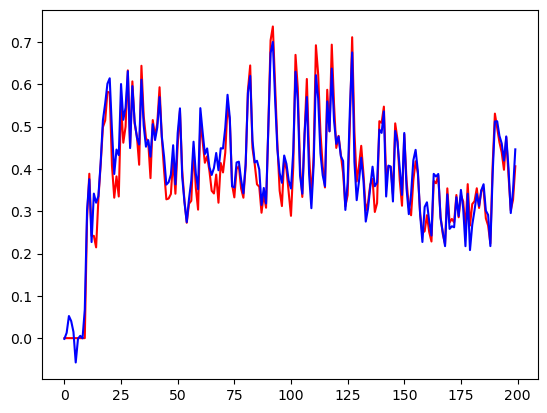

In [13]:
# Get the first sample in training set,
# and transform it to Variable.
dataiter = iter(trainloader)
train_u, train_y = next(dataiter)
train_u, train_y = Variable(train_u), Variable(train_y)
if use_cuda: train_u, train_y = train_u.cuda(), train_y.cuda()

# Make a prediction with our trained ESN
y_predicted = esn(train_u)

# Print training MSE and NRMSE
print(("Train MSE: {}".format(echotorch.utils.mse(y_predicted.data, train_y.data))))
print(("Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, train_y.data))))
print("")

# Get the first sample in test set,
# and transform it to Variable.
dataiter = iter(testloader)
test_u, test_y = next(dataiter)
test_u, test_y = Variable(test_u), Variable(test_y)
if use_cuda: test_u, test_y = test_u.cuda(), test_y.cuda()

# Make a prediction with our trained ESN
y_predicted = esn(test_u)

# Print test MSE and NRMSE
print(("Test MSE: {}".format(echotorch.utils.mse(y_predicted.data, test_y.data))))
print(("Test NRMSE: {}".format(echotorch.utils.nrmse(y_predicted.data, test_y.data))))
print("")

# Show target and predicted
plt.plot(test_y[0, :plot_length, 0].data, 'r')
plt.plot(y_predicted[0, :plot_length, 0].data, 'b')
plt.show()